 # **Some Regards on using Physics-Informed Neural Networks for Solving Two-Dimensional Elasticity Problems**
 
 **Authors:** Estevão Fuzaro de Almeida & Samuel da Silva
 
 **Last modified:** January 28, 2025
 
 ---

## **Case 1: plate under a vertical triangular load**

Consider a triangular plate with a linearly increasing load as shown in the figure below, with the stress $q_0 (\textrm{N/m}^2)$ at $x=L$.

<center><img src="imgs/placa1_bg.jpg"  width="400" height="450"></center>

The idea is to use the elastic equilibrium equations and find the stresses of the plate using a physics-informed neural network. These conservation equations are given by:
$$
\begin{matrix}
\frac{\partial \sigma_x}{\partial x} + \frac{\partial \tau_{xy}}{\partial y} = 0 \\
\frac{\partial \tau_{xy}}{\partial x} + \frac{\partial \sigma_y}{\partial y} = 0 \\
\frac{\partial^2 \sigma_x}{\partial x^2} + \frac{\partial^2 \sigma_y}{\partial x^2} + \frac{\partial^2 \sigma_x}{\partial y^2} + \frac{\partial^2 \sigma_y}{\partial y^2} = 0
\end{matrix}
$$
which can be simplified into two main equations:
$$
\begin{matrix}
\nabla\cdot\sigma = 0 \\
\nabla^2\left(\sigma_x + \sigma_y\right) = 0
\end{matrix}
$$

The boundary conditions can be easily obtained by evaluating faces $AB$ and $AC$ (face $BC$ is only used to find stresses at the clamping, so it is not as important).
* **Face $AB$**:
  * $y=0$
  * $∀x$
  * $0 \leq x \leq L$

$$\hat{n}_{AB} = -\hat{j};~~~~\vec{t}_{AB} = \left[\sigma\right]\hat{n}_{AB} ⇒$$

$$\vec{t}_{AB} = \begin{bmatrix} \sigma_x & \tau_{xy} \\ \tau_{xy} & \sigma_y\end{bmatrix}\begin{Bmatrix}0 \\ -1\end{Bmatrix} = \begin{Bmatrix}0 \\ q(x)\end{Bmatrix},~\textrm{where}~q(x) = -\frac{q_0}{L}x$$

$$\therefore \boxed{\tau_{xy}(x,0) = 0}~~\textrm{and}~~\boxed{\sigma_y(x,0)=\frac{q_0}{L}x}$$

* **Face $AC$**:
  * $y=x$
  * $0 \leq x \leq L$

$$\hat{n}_{AC} = -\frac{1}{\sqrt{2}}\hat{i} + \frac{1}{\sqrt{2}}\hat{j};~~~~\vec{t}_{AC} = \left[\sigma\right]\hat{n}_{AC} ⇒$$

$$\vec{t}_{AC} = \begin{bmatrix} \sigma_x & \tau_{xy} \\ \tau_{xy} & \sigma_y\end{bmatrix}\begin{Bmatrix}-\frac{1}{\sqrt{2}} \\ \frac{1}{\sqrt{2}}\end{Bmatrix} = \begin{Bmatrix}0 \\ 0\end{Bmatrix}$$

$$\therefore \boxed{\sigma_x(x,x) = \tau_{xy}(x,x)}~~\textrm{and}~~\boxed{\sigma_y(x,x) = \tau_{xy}(x,x)}$$

### **1. Initialization**

In [1]:
import numpy as np
import sciann as sn
import os
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
from matplotlib import rc
from tensorflow import keras as ks
import subprocess

# Configure the seed for uniform network initialization
seed = 1998
np.random.seed(seed)
sn.tf.random.set_seed(seed)

# Check GPU availability and use it if available
gpu_available = sn.tf.config.list_physical_devices('GPU')
if gpu_available:
    print("TensorFlow v.", sn.tf.__version__)
    print("Number of Available GPUs:", len(sn.tf.config.experimental.list_physical_devices('GPU')))
    command = "nvidia-smi --query-gpu=name,memory.total --format=csv,noheader,nounits"
    output = subprocess.check_output(command, shell=True, encoding="utf-8")
    lines = output.strip().split("\n")
    for idx, line in enumerate(lines):
        name, memory = line.strip().split(",")
        print(f"GPU {idx} - Name: {name}, Total Memory: {memory} MB")
    sn.tf.config.experimental.set_memory_growth(gpu_available[0], True)
    print("GPU Loaded:",name)

# Configuring fonts for the plots based on LaTeX
rc('font', **{'family': 'serif', 'serif': ['Computer Modern'],'size': '18'})
rc('text', usetex=True)

---------------------- SCIANN 0.7.0.1 ---------------------- 
For details, check out our review paper and the documentation at: 
 +  "https://www.sciencedirect.com/science/article/pii/S0045782520307374", 
 +  "https://arxiv.org/abs/2005.08803", 
 +  "https://www.sciann.com". 

 Need support or would like to contribute, please join sciann`s slack group: 
 +  "https://join.slack.com/t/sciann/shared_invite/zt-ne1f5jlx-k_dY8RGo3ZreDXwz0f~CeA" 
 
TensorFlow Version: 2.10.0 
Python Version: 3.9.13 (tags/v3.9.13:6de2ca5, May 17 2022, 16:36:42) [MSC v.1929 64 bit (AMD64)] 

TensorFlow v. 2.10.0
Number of Available GPUs: 1
GPU 0 - Name: NVIDIA GeForce RTX 3050 Laptop GPU, Total Memory:  4096 MB
GPU Loaded: NVIDIA GeForce RTX 3050 Laptop GPU


In [2]:
# Setting the case to be evaluated
case1 = "ToyProblem_1-1000"
path = "training/" + case1
weightPath = path + "/weights"
# Checking if the folder exists and creating it if it does not
isExist = os.path.exists(path)
if not isExist:
   os.makedirs(path)
   os.makedirs(weightPath)
   print("New folders created: ")
   print(path)
   print(weightPath)
else:
   print("Folders already exist: ")
   print(path)
   print(weightPath)

Folders already exist: 
training/ToyProblem_1-1000
training/ToyProblem_1-1000/weights


### **2. Exact Solution**

Defining a mesh of points that will be used to obtain the exact solution. Subsequently, a coarser mesh will be evaluated for training.

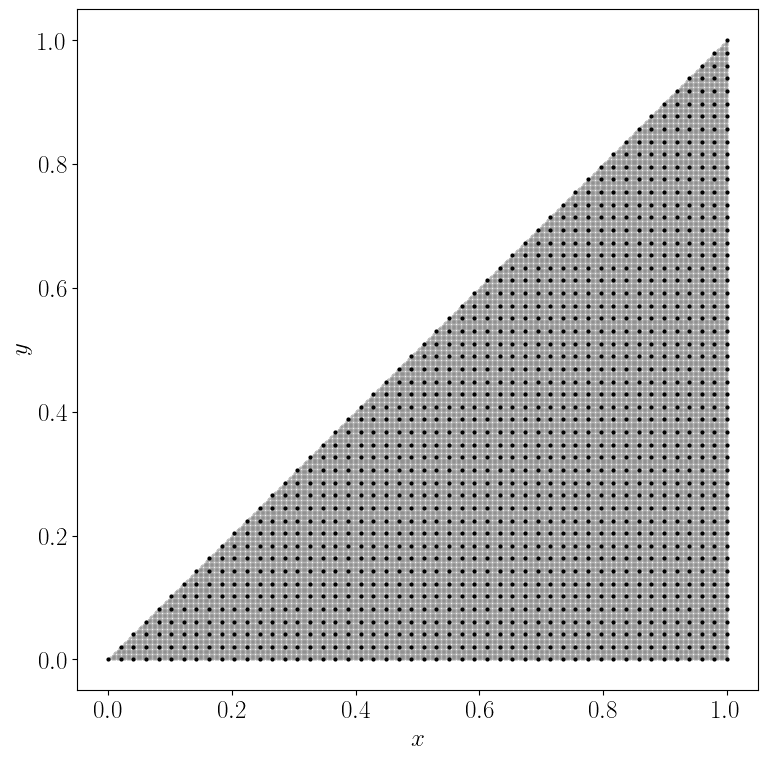

In [3]:
# Definition of parameters
L = 1.0     # Plate length [m]
q0 = 10.0   # Load [N/m²]

# Creating a 500x500 mesh = 125250 points over the plate for the exact solution
gridData = 500  # Number of elements on the mesh side
x_data, y_data = np.meshgrid(
  np.linspace(0,L,gridData),
  np.linspace(0,L,gridData)
  )
# Flattening the grid to vector format
varD = np.int64(len(x_data)*(len(y_data)+1)/2)
xxD = np.zeros(varD)
yyD = np.zeros(varD)
kk = 0
for ii in range(len(x_data)):
  for jj in range(len(y_data)):
    if x_data[ii,jj]>=y_data[ii,jj]:
      xxD[kk] = x_data[ii,jj]
      yyD[kk] = y_data[ii,jj]
      kk = kk + 1

# Creating a 50x50 mesh = 1275 points over the plate for training
gridTrain = 50  # Number of elements on the mesh side
x_train, y_train = np.meshgrid(
  np.linspace(0,L,gridTrain),
  np.linspace(0,L,gridTrain)
  )
# Flattening the grid to vector format
varT = np.int64(len(x_train)*(len(y_train)+1)/2)
xxT = np.zeros(varT)
yyT = np.zeros(varT)
kk = 0
for ii in range(len(x_train)):
  for jj in range(len(y_train)):
    if x_train[ii,jj]>=y_train[ii,jj]:
      xxT[kk] = x_train[ii,jj]
      yyT[kk] = y_train[ii,jj]
      kk = kk + 1

# Plotting the points that will be used for training
plt.figure(figsize=(8, 8))
plt.plot(xxD, yyD, color='gray', linestyle='none', marker='o', markersize=0.25)
plt.plot(xxT, yyT, color='black', linestyle='none', marker='o', markersize=2)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.axis('scaled')
plt.tight_layout()
plt.show()

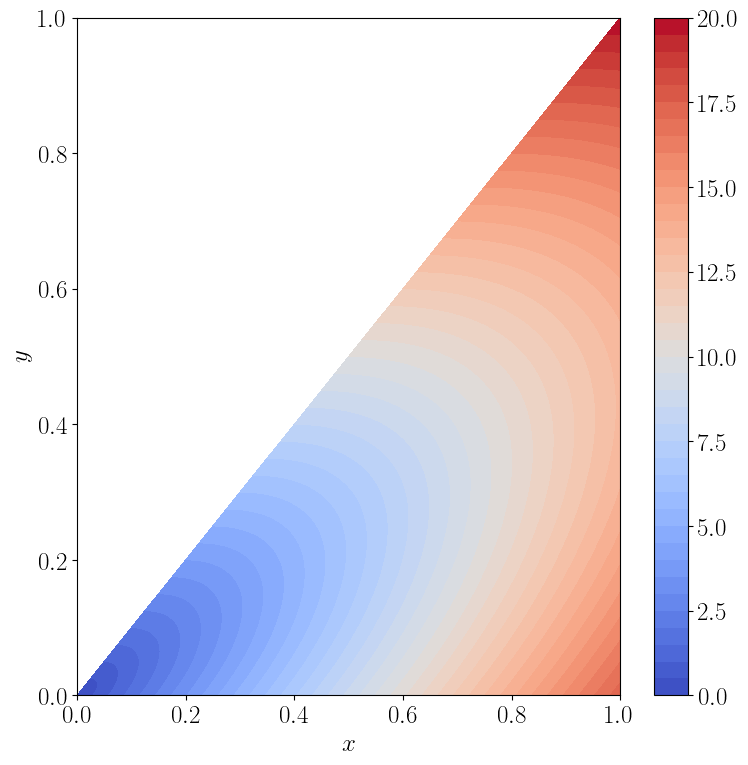

In [4]:
# Exact solution over the fine mesh (500x500)
# Tension state - exact
sx_data = -(q0/L)*x_data + 2*(q0/L)*y_data
sy_data = (q0/L)*x_data
txy_data = (q0/L)*y_data

# Obtention of the von Mises stress - exact
sigma_VM_data = np.zeros((len(x_data),len(y_data)))
sx_data_ = np.zeros((len(x_data),len(y_data)))
sy_data_ = np.zeros((len(x_data),len(y_data)))
txy_data_ = np.zeros((len(x_data),len(y_data)))
for ii in range(len(x_data)):
  for jj in range(len(y_data)):
    # Stresses tensor
    sigma = np.array([[sx_data[ii,jj], txy_data[ii,jj], 0],
                      [txy_data[ii,jj], sy_data[ii,jj], 0],
                      [0, 0, 0]]
                      )
    # Principal stresses
    eigval = np.linalg.eigvals(sigma)
    eigval[::-1].sort()
    S1 = eigval[0]
    S2 = eigval[1]
    S3 = eigval[2]
    # Von Mises stress
    if x_data[ii,jj]<y_data[ii,jj]:
      sigma_VM_data[ii,jj] = np.nan
      sx_data_[ii,jj] = np.nan
      sy_data_[ii,jj] = np.nan
      txy_data_[ii,jj] = np.nan
    elif x_data[ii,jj]>=y_data[ii,jj]:
      sigma_VM_data[ii,jj] = np.sqrt(((S1 - S2)**2 + (S2 - S3)**2 + (S3 - S1)**2)/2)
      sx_data_[ii,jj] = sx_data[ii,jj]
      sy_data_[ii,jj] = sy_data[ii,jj]
      txy_data_[ii,jj] = txy_data[ii,jj]

# Plot of the von Mises stress field - exact
plt.figure(figsize=(8, 8))
plt.contourf(x_data, y_data, sigma_VM_data, levels = 40, cmap='coolwarm')
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.tight_layout()
plt.show()

### **3. Structuring the Neural Networks**

The first step is to construct the stress approximation space, with $(x,y)$ as the independent variables and $\mathcal{N}_{\sigma_{x}}$, $\mathcal{N}_{\sigma_{y}}$, $\mathcal{N}_{\tau_{xy}}$ as the neural networks for each of the stresses.
$$
\begin{matrix}
\hat{\sigma}_{x} : (x,y) \rightarrow \mathcal{N}_{\sigma_{x}}(x,y;\bf{W},\bf{b}) \\
\hat{\sigma}_{y} : (x,y) \rightarrow \mathcal{N}_{\sigma_{y}}(x,y;\bf{W},\bf{b}) \\
\hat{\tau}_{xy} : (x,y) \rightarrow \mathcal{N}_{\tau_{xy}}(x,y;\bf{W},\bf{b})
\end{matrix}
$$

In [5]:
sn.reset_session()

# Defining the variables x and y
x = sn.Variable('x')
y = sn.Variable('y')

# Defining the neural networks with:
#   - 2 hidden layers;
#   - 30 neurons per hidden layer;
#   - Hyperbolic tangent activation function.
sx = sn.Functional('sx', [x,y], 2*[30], 'tanh')
sy = sn.Functional('sy', [x,y], 2*[30], 'tanh')
txy = sn.Functional('txy', [x,y], 2*[30], 'tanh')

The second step involves optimizing the model using the `SciModel` interface.

The input variables are $(x,y)$ and the equilibrium equations are:
$$\begin{matrix}
\frac{\partial \sigma_x}{\partial x} + \frac{\partial \tau_{xy}}{\partial y} = 0 \\
\frac{\partial \tau_{xy}}{\partial x} + \frac{\partial \sigma_y}{\partial y} = 0 \\
\frac{\partial^2 \sigma_x}{\partial x^2} + \frac{\partial^2 \sigma_y}{\partial x^2} + \frac{\partial^2 \sigma_x}{\partial y^2} + \frac{\partial^2 \sigma_y}{\partial y^2} = 0
\end{matrix}$$

In [6]:
# Defining the equilibrium equations
L1 = sn.rename(sn.diff(sx, x) + sn.diff(txy, y), 'L1')
L2 = sn.rename(sn.diff(txy, x) + sn.diff(sy, y), 'L2')
L3 = sn.rename(sn.diff(sx, x, order=2) + sn.diff(sy, x, order=2) + sn.diff(sx, y, order=2) + sn.diff(sy, y, order=2), 'L3')

Finally, we define the boundary conditions of the triangular plate, which are:

$$\tau_{xy}(x,0) = 0$$

$$\sigma_y(x,0)=\frac{q_0}{L}x$$

$$\sigma_x(x,x) = \tau_{xy}(x,x)$$

$$\sigma_y(x,x) = \tau_{xy}(x,x)$$

In [7]:
# Boundary conditions
# Face AB
C1 = sn.rename((y==0)*(txy), 'C1')
C2 = sn.rename((y==0)*(sy - (q0/L)*x), 'C2')
# Face AC
C3 = sn.rename((y==x)*(sx - txy), 'C3')
C4 = sn.rename((y==x)*(sy - txy), 'C4')

Next, we define the objective functions, i.e., those that will be minimized during training.

In [8]:
# Defining the target functions - 3 equilibrium equations + 4 BCs
targets = [L1, L2, L3, C1, C2, C3, C4]

Subsequently, the network model is created and training begins.

> **NOTE:** If we need to load any previous training, we must "uncomment" the beginning of the cell and comment out the rest.
> 
> Thus, the model will be loaded with the previous weights, just needing to evaluate (`eval`) the data.

In [9]:
# Model parameters
epochs = 1000     # epochs number for training
lr = 0.01         # learning rate - initial
batch = 50        # batch size - it must be less or equal to gridTrain
loss_func = 'mse' # loss function - mean squared error
optim = sn.tf.keras.optimizers.legacy.Adam(learning_rate=lr) # optimizer - Adam

#---------(UN)COMMENT-----------------------------------------------------------
# # Load the model from a previous training
# print("Case loaded:", case1)
# m = sn.SciModel([x, y], targets=targets, loss_func=loss_func, optimizer=optim,
#                 load_weights_from='training/'+case1+'/weights/weights.hdf5')
#-------------------------------------------------------------------------------

#---------(UN)COMMENT-----------------------------------------------------------
# Model definition and training
print("Case to be trained:", case1)
m = sn.SciModel([x, y], targets=targets, loss_func=loss_func, optimizer=optim)
          # load_weights_from='training/Physics_0001-3000/weights/weights.hdf5')
                # if you want to load a previous training and continue training.
if (batch > gridTrain):
  import sys
  sys.exit("Error! The batch size must be less or equal to gridTrain")
elif (batch <= gridTrain):
    # Training the model
    h = m.train([x_train, y_train], len(targets)*['zero'],
                epochs=epochs, batch_size=batch, learning_rate=lr,
                save_weights={"path": 'training/'+case1+'/weights/', "freq": epochs, "best": False})
#------------------------------------------------------------------------------------------------------------------------
print(m)

Case to be trained: ToyProblem_1-1000

Total samples: 2500 
Batch size: 50 
Total batches: 50 

Epoch 1/1000
50/50 [==============================] - 3s 18ms/step - batch: 24.5000 - size: 50.0000 - loss: 0.9374 - L1_loss: 0.0992 - L2_loss: 0.0337 - L3_loss: 0.3076 - C1_loss: 0.0011 - C2_loss: 0.4721 - C3_loss: 0.0059 - C4_loss: 0.0177 - lr: 0.0100 - time: 3.2723
Epoch 2/1000
50/50 [==============================] - 1s 16ms/step - batch: 24.5000 - size: 50.0000 - loss: 0.3448 - L1_loss: 0.0026 - L2_loss: 0.0031 - L3_loss: 0.0099 - C1_loss: 0.0085 - C2_loss: 0.2820 - C3_loss: 0.0083 - C4_loss: 0.0305 - lr: 0.0100 - time: 0.8080
Epoch 3/1000
50/50 [==============================] - 1s 17ms/step - batch: 24.5000 - size: 50.0000 - loss: 0.2821 - L1_loss: 0.0023 - L2_loss: 0.0070 - L3_loss: 0.0098 - C1_loss: 0.0193 - C2_loss: 0.1790 - C3_loss: 0.0102 - C4_loss: 0.0544 - lr: 0.0100 - time: 0.8630
Epoch 4/1000
50/50 [==============================] - 1s 16ms/step - batch: 24.5000 - size: 50.00

In [12]:
# Rename the weights file in order to avoid overwriting
isExist = os.path.exists(weightPath+"/-end.hdf5")
if isExist:
    os.rename(weightPath+"/-end.hdf5", weightPath+"/weights.hdf5")
    print("Saved weights as: weights.hdf5")

Saved weights as: weights.hdf5


### **4. Prediction after training**

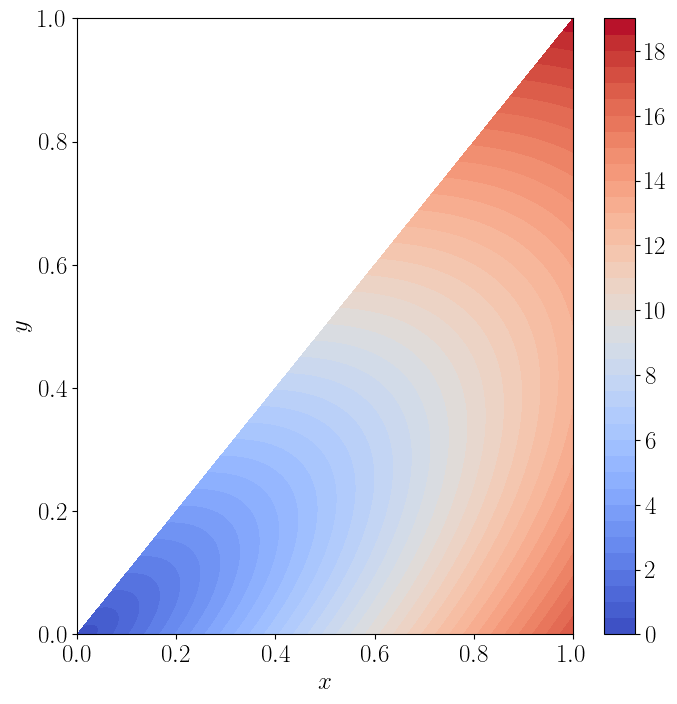

In [19]:
# Stresses after training the network - over the 500x500 mesh (fine mesh)
sx_pred = sx.eval([x_data, y_data])
sy_pred = sy.eval([x_data, y_data])
txy_pred = txy.eval([x_data, y_data])

# Obtention of the von Mises stress - PINN
sigma_VM_NN = np.zeros((len(x_data),len(y_data)))
for ii in range(len(x_data)):
  for jj in range(len(y_data)):
    # Stresses tensor
    sigma = np.array([[sx_pred[ii,jj], txy_pred[ii,jj], 0],
                      [txy_pred[ii,jj], sy_pred[ii,jj], 0],
                      [0, 0, 0]]
                      )
    # Principal stresses
    eigval = np.linalg.eigvals(sigma)
    eigval[::-1].sort()
    S1 = eigval[0]
    S2 = eigval[1]
    S3 = eigval[2]
    # Von Mises stress
    if x_data[ii,jj]<y_data[ii,jj]:
      sigma_VM_NN[ii,jj] = np.nan
    elif x_data[ii,jj]>=y_data[ii,jj]:
      sigma_VM_NN[ii,jj] = np.sqrt(((S1 - S2)**2 + (S2 - S3)**2 + (S3 - S1)**2)/2)

# Plotting the von Mises stress field - PINN
plt.figure(figsize=(8, 8))
plt.contourf(x_data, y_data, sigma_VM_NN, cmap='coolwarm', levels=40)
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.show()

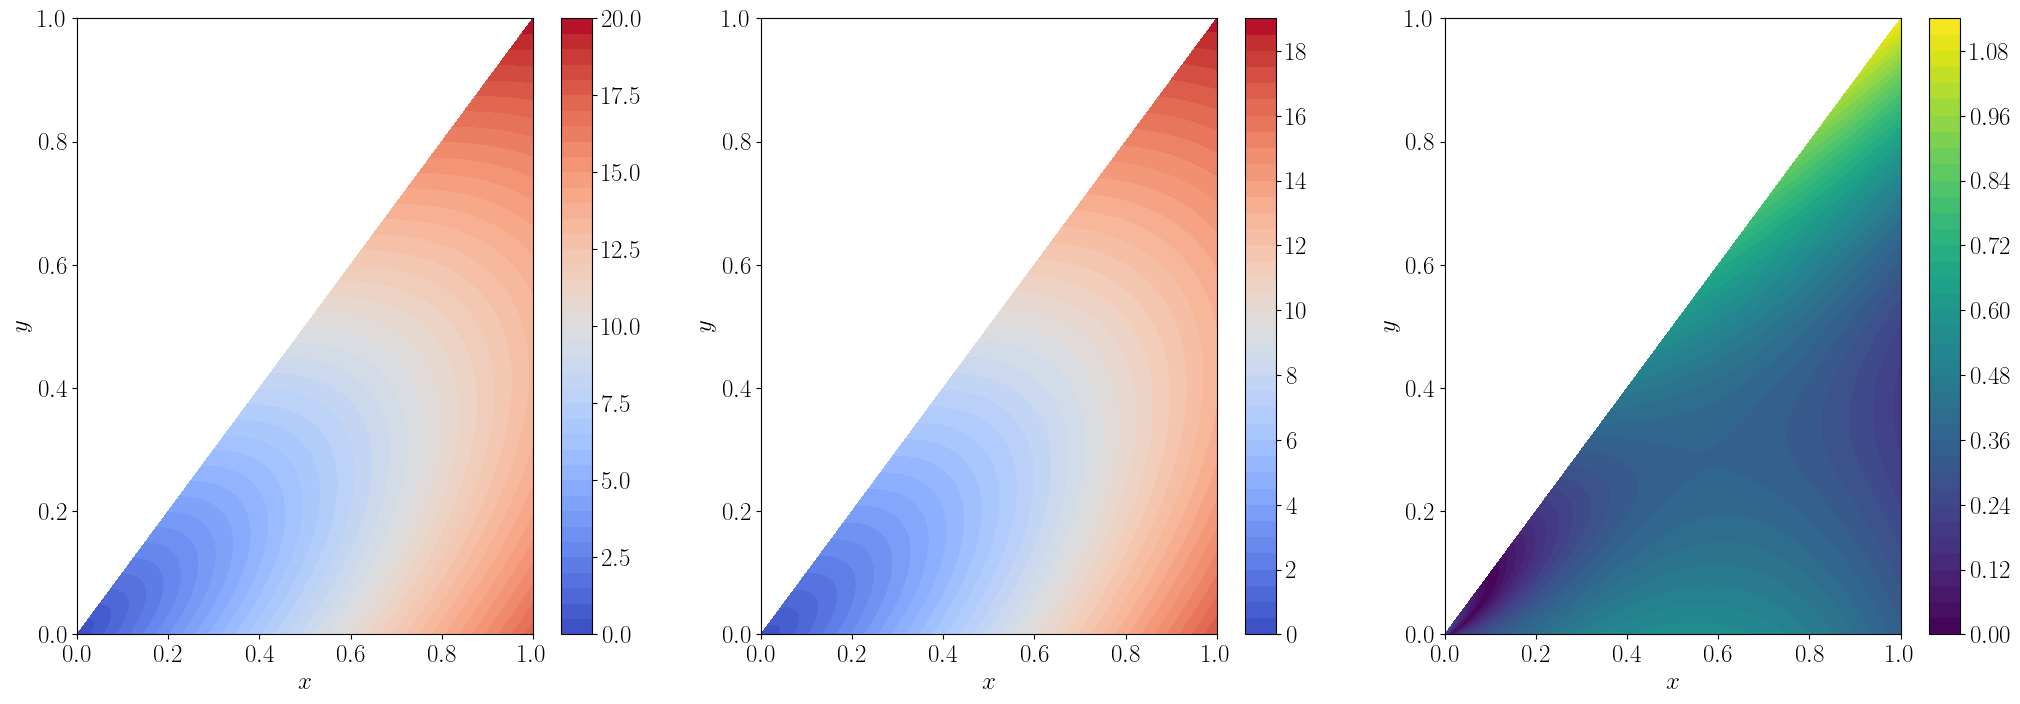

In [20]:
# Comparison between the von Mises stress fields - exact and PINN
plt.figure(figsize=(25, 8))
plt.subplot(1, 3, 1)
plt.contourf(x_data, y_data, sigma_VM_data, cmap='coolwarm', levels=40)
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$y$')

plt.subplot(1, 3, 2)
plt.contourf(x_data, y_data, sigma_VM_NN, cmap='coolwarm', levels=40)
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$y$')

plt.subplot(1, 3, 3)
plt.contourf(x_data, y_data, np.abs(sigma_VM_data - sigma_VM_NN), cmap='viridis', levels=40)
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.show()

In [21]:
# Variables that can be plotted from the history
h.history.keys()

dict_keys(['loss', 'L1_loss', 'L2_loss', 'L3_loss', 'C1_loss', 'C2_loss', 'C3_loss', 'C4_loss', 'lr', 'time'])

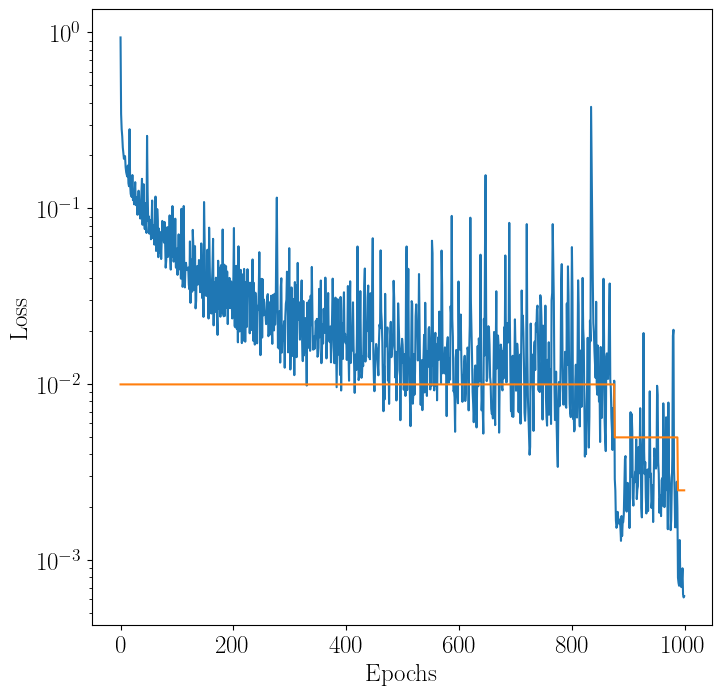

In [23]:
time = np.cumsum(h.history['time'])
# Plotting the loss and learning rate
plt.figure(figsize=(10, 6))
plt.semilogy(h.history['loss'], label='loss')
plt.semilogy(h.history['lr'], label='lr')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

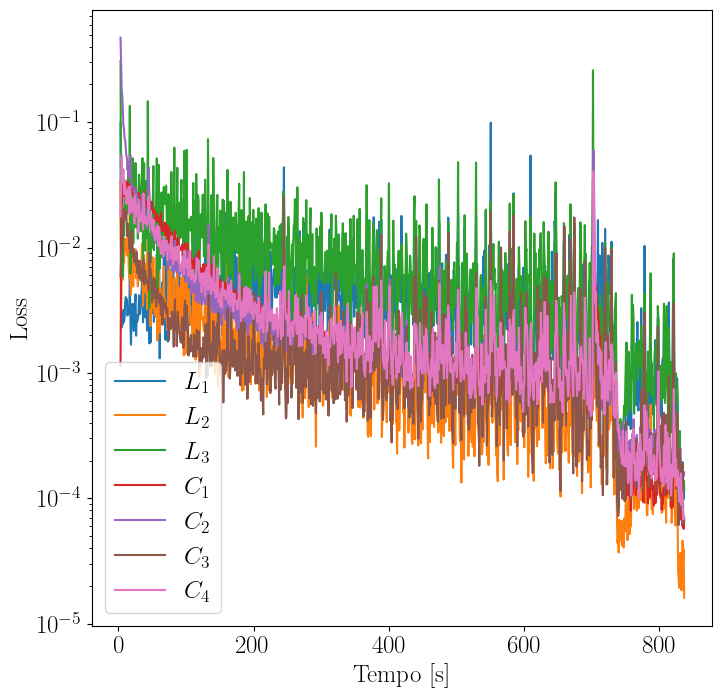

In [24]:
# Plotting the loss functions individually
plt.figure(figsize=(10, 6))
plt.semilogy(time, h.history['L1_loss'], label='$L_1$')
plt.semilogy(time, h.history['L2_loss'], label='$L_2$')
plt.semilogy(time, h.history['L3_loss'], label='$L_3$')
plt.semilogy(time, h.history['C1_loss'], label='$C_1$')
plt.semilogy(time, h.history['C2_loss'], label='$C_2$')
plt.semilogy(time, h.history['C3_loss'], label='$C_3$')
plt.semilogy(time, h.history['C4_loss'], label='$C_4$')
plt.legend()
plt.xlabel('Tempo [s]')
plt.ylabel('Loss')
plt.show()

In [25]:
# Saving the data to files
np.savetxt('training/'+case1+'/loss.txt',h.history['loss'])
np.savetxt('training/'+case1+'/L1_loss.txt',h.history['L1_loss'])
np.savetxt('training/'+case1+'/L2_loss.txt',h.history['L2_loss'])
np.savetxt('training/'+case1+'/L3_loss.txt',h.history['L3_loss'])
np.savetxt('training/'+case1+'/C1_loss.txt',h.history['C1_loss'])
np.savetxt('training/'+case1+'/C2_loss.txt',h.history['C2_loss'])
np.savetxt('training/'+case1+'/C3_loss.txt',h.history['C3_loss'])
np.savetxt('training/'+case1+'/C4_loss.txt',h.history['C4_loss'])
np.savetxt('training/'+case1+'/lr.txt',h.history['lr'])
np.savetxt('training/'+case1+'/time.txt',np.cumsum(h.history['time']))
np.savetxt('training/'+case1+'/x_data.txt',x_data)
np.savetxt('training/'+case1+'/y_data.txt',y_data)
np.savetxt('training/'+case1+'/x_train.txt',x_train)
np.savetxt('training/'+case1+'/y_train.txt',y_train)
np.savetxt('training/'+case1+'/sigma_VM_data.txt',sigma_VM_data)
np.savetxt('training/'+case1+'/sigma_VM_NN.txt',sigma_VM_NN)